In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import initializers
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 10
IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_CHANNELS = 3
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "CIFAR10_weight_init"
PATH = ""

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def CIFAR10model(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Train

In [9]:
models = []
accuracies = []
predictions = []
initializer = ["Zero","Ones","Random Normal","Random Uniform","Identity","Orthogonal","Glorot Normal","Glorot Uniform"]
for i in range(len(initializer)):

    print(f"Train model {i}")
    print(f"Weight init method: {initializer[i]} ")
    model = CIFAR10model(IMAGE_SIZE,NUM_CLASSES,NUM_CHANNELS)
    
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            if(initializer[i] == "Zero"):
                layer.kernel_initializer = initializers.Zeros()
            elif(initializer[i] == "Ones"):
                layer.kernel_initializer = initializers.Ones()
            elif(initializer[i] == "Random Normal"):
                layer.kernel_initializer = initializers.RandomNormal()
            elif(initializer[i] == "Random Unifrom"):
                layer.kernel_initializer = initializers.RandomUniform()
            elif(initializer[i] == "Identity"):
                layer.kernel_initializer = initializers.Identity()
            elif(initializer[i] == "Orthogonal"):
                layer.kernel_initializer = initializers.Orthogonal()
            elif(initializer[i] == "Glorot Normal"):
                layer.kernel_initializer = initializers.GlorotNormal()
            elif(initializer[i] == "Glorot Unifrom"):
                layer.kernel_initializer = initializers.GlorotUnifrom()
          
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', min_delta=0.01, patience=3)
    model.fit(x_train,y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_val,y_val),
              shuffle = True,
              callbacks=[es])
    models.append(model)
    y_prob = model.predict(x_test) 
    predictions.append(y_prob.argmax(axis=-1))
    acc = model.evaluate(x_test,y_testc)[1]
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")


Train model 0
Weight init method: Zero 
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 90us/step - loss: 2.2199 - accuracy: 0.1654 - val_loss: 2.2462 - val_accuracy: 0.1776
Epoch 2/10
 3584/40000 [=>............................] - ETA: 1s - loss: 2.1375 - accuracy: 0.2006

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


40000/40000 [==============================] - 2s 54us/step - loss: 2.0858 - accuracy: 0.2254 - val_loss: 2.0706 - val_accuracy: 0.2467
Epoch 3/10
40000/40000 [==============================] - 2s 55us/step - loss: 1.9938 - accuracy: 0.2681 - val_loss: 1.9576 - val_accuracy: 0.2869
Epoch 4/10
40000/40000 [==============================] - 2s 55us/step - loss: 1.9309 - accuracy: 0.3015 - val_loss: 1.9022 - val_accuracy: 0.3132
Epoch 5/10
40000/40000 [==============================] - 2s 54us/step - loss: 1.8840 - accuracy: 0.3178 - val_loss: 1.8639 - val_accuracy: 0.3162
Epoch 6/10
40000/40000 [==============================] - 2s 55us/step - loss: 1.8471 - accuracy: 0.3282 - val_loss: 1.8264 - val_accuracy: 0.3404
Epoch 7/10
40000/40000 [==============================] - 2s 54us/step - loss: 1.8150 - accuracy: 0.3399 - val_loss: 1.7988 - val_accuracy: 0.3467
Epoch 8/10
40000/40000 [==============================] - 2s 55us/step - loss: 1.7865 - accuracy: 0.3476 - val_loss: 1.7722 - val

# Results

# Accuracy

In [10]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df["weight_init_method"] = initializer
display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,weight_init_method
0,0.3693,Zero
1,0.3702,Ones
2,0.3643,Random Normal
3,0.3669,Random Uniform
4,0.3724,Identity
5,0.3574,Orthogonal
6,0.3813,Glorot Normal
7,0.3670,Glorot Uniform


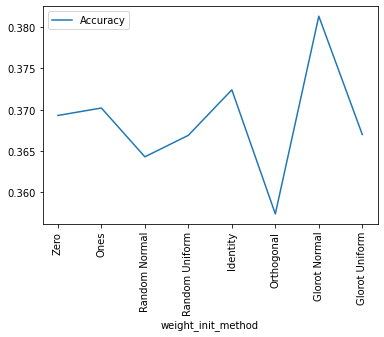

In [11]:
import matplotlib.pyplot as plt

accuracy_df.plot(x="weight_init_method", y="Accuracy",rot = 90)

plt.show()


In [12]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 8/8 [00:00<00:00, 103.10it/s]


## Correlation between models

In [13]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df.columns = initializer
correlation_matrix_df.index = initializer
display(correlation_matrix_df)
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,Zero,Ones,Random Normal,Random Uniform,Identity,Orthogonal,Glorot Normal,Glorot Uniform
Zero,NaN,0.571954,0.582406,0.616094,0.608067,0.548292,0.585241,0.592685
Ones,0.571954,NaN,0.609105,0.557644,0.579337,0.609288,0.592012,0.623624
Random Normal,0.582406,0.609105,NaN,0.623185,0.627703,0.563252,0.589517,0.583329
Random Uniform,0.616094,0.557644,0.623185,NaN,0.620885,0.516818,0.541248,0.579634
Identity,0.608067,0.579337,0.627703,0.620885,NaN,0.550771,0.593258,0.607815
Orthogonal,0.548292,0.609288,0.563252,0.516818,0.550771,NaN,0.545711,0.560359
Glorot Normal,0.585241,0.592012,0.589517,0.541248,0.593258,0.545711,NaN,0.612390
Glorot Uniform,0.592685,0.623624,0.583329,0.579634,0.607815,0.560359,0.612390,NaN


Average correlation: 0.5854151706135186
